In [20]:
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
import time
import re
import math
from matplotlib import pyplot as plt
import tensorflow as tf
import wandb
from wandb.keras import WandbCallback

path = "/home/andrew/ros_ws/src/2020T1_competition/controller/ol_3"
labels = ['00', '01', '02', '10', '11', '12'] # one label representing each combination of foward and turning

In [21]:
img_sets = []
from random import randint

# load and augment dataset
for filename in os.listdir(path):
    if filename.endswith(".jpg"): 
        label = filename.split('_')[0]
        img = np.array(Image.open(path+"/"+filename))
        img_sets.append(np.array([[img, labels.index(label)]]))

        # todo: make this less ugly
        h, w = img.shape
        img = img.reshape(h, w, 1)
        img_aug = tf.keras.preprocessing.image.apply_affine_transform(img, theta=randint(-2,2), tx=randint(0,5),
                                                                ty=randint(0,5), shear=randint(-10,10), row_axis=0, col_axis=1,
                                                                fill_mode='nearest', cval=0.0, order=1)
        img_aug = img.reshape(h, w)
        img_sets.append(np.array([[img_aug, labels.index(label)]]))
                                                                


4162
3
(180, 320)


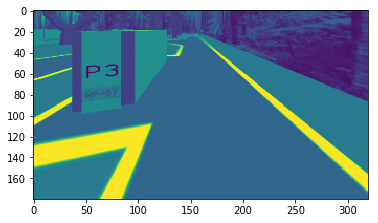

In [22]:
# making sure things are cool and good
n = 1
plt.imshow(img_sets[n][0][0])
plt.show
print(len(img_sets))
print(img_sets[n][0][1])
print(img_sets[n][0][0].shape)

In [23]:
all_dataset = np.concatenate(img_sets, axis=0)
np.random.shuffle(all_dataset)

In [24]:
X_dataset_orig = np.array([data[0] for data in all_dataset[:]])
Y_dataset_orig = np.array([[data[1]] for data in all_dataset]).T

NUMBER_OF_LABELS = 6
CONFIDENCE_THRESHOLD = 0.01

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
  
# Normalize X (images) dataset
X_dataset = X_dataset_orig/255.

# Convert Y dataset to one-hot encoding
Y_dataset = convert_to_one_hot(Y_dataset_orig, NUMBER_OF_LABELS).T

In [25]:
n, h, w = X_dataset.shape
X_dataset = X_dataset.reshape(n, h, w, 1)
print(X_dataset.shape)

(4162, 180, 320, 1)


In [26]:
VALIDATION_SPLIT = 0.2

print("Total examples: {}\nTraining examples: {}\nTest examples: {}".
      format(X_dataset.shape[0],
             math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT)),
             math.floor(X_dataset.shape[0] * VALIDATION_SPLIT)))
print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))

Total examples: 4162
Training examples: 3330.0
Test examples: 832.0
X shape: (4162, 180, 320, 1)
Y shape: (4162, 6)


In [27]:
# model setup 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

In [28]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [29]:
# input_shape needs to match the input, duh
conv_model = models.Sequential()
# this creates our convolution kernel, (3,3) is the size of it
conv_model.add(layers.Conv2D(12, (5, 5), activation='relu',
                             input_shape=(h, w, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(24, (5, 5), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(36, (5, 5), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(6*36, activation='relu'))
conv_model.add(layers.Dense(6, activation='softmax'))

In [30]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 176, 316, 12)      312       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 88, 158, 12)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 84, 154, 24)       7224      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 42, 77, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 38, 73, 36)        21636     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 19, 36, 36)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24624)            

In [31]:
reset_weights(conv_model)

In [33]:
wandb.init(project='enph353', entity='nullcline')
config = wandb.config

In [34]:
lr= 1e-4
config = wandb.config
config.learning_rate = lr

conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(lr=lr),
                   metrics=['acc'])

In [35]:
history_conv = conv_model.fit(X_dataset, Y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=20, 
                              batch_size=100,
                              callbacks=[WandbCallback()])

Train on 3329 samples, validate on 833 samples
Epoch 1/20
3329/3329 [==============================] - 73s 22ms/sample - loss: 0.6742 - acc: 0.7459 - val_loss: 0.5090 - val_acc: 0.8271
Epoch 2/20
3329/3329 [==============================] - 75s 22ms/sample - loss: 0.4271 - acc: 0.8453 - val_loss: 0.4040 - val_acc: 0.8571
Epoch 3/20
3329/3329 [==============================] - 76s 23ms/sample - loss: 0.3759 - acc: 0.8636 - val_loss: 0.4173 - val_acc: 0.8595
Epoch 4/20
3329/3329 [==============================] - 72s 22ms/sample - loss: 0.3489 - acc: 0.8711 - val_loss: 0.3803 - val_acc: 0.8643
Epoch 5/20
3329/3329 [==============================] - 70s 21ms/sample - loss: 0.3114 - acc: 0.8859 - val_loss: 0.3526 - val_acc: 0.8800
Epoch 6/20
3329/3329 [==============================] - 71s 21ms/sample - loss: 0.2875 - acc: 0.8916 - val_loss: 0.3295 - val_acc: 0.8812
Epoch 7/20
3329/3329 [==============================] - 68s 20ms/sample - loss: 0.2564 - acc: 0.9009 - val_loss: 0.3124 - val

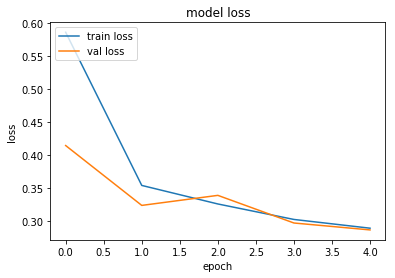

In [16]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

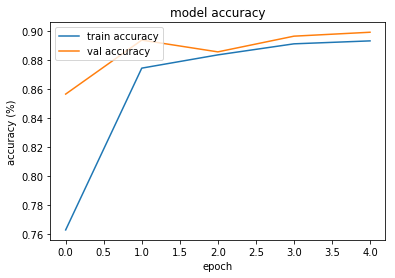

In [17]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()